## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
originalImages = []
cornerImages = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        originalImages.append(img)
        cornerImage = cv2.drawChessboardCorners(img.copy(), (9,6), corners, ret)
        cornerImages.append(cornerImage)

testImage = cv2.imread("../test_images/test1.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, testImage.shape[0:2], None, None) 


In [ ]:
###Undistort Image

Text(0.5,1,'Undistorted')

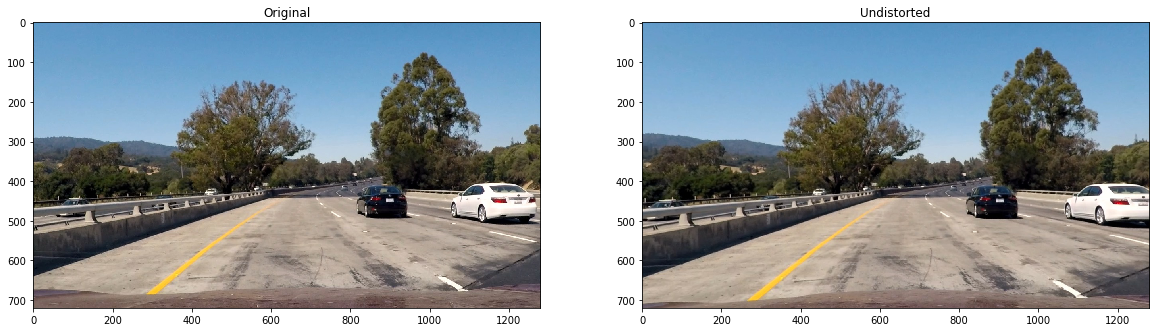

In [3]:
undist = cv2.undistort(testImage, mtx, dist, None, mtx) 
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)) 
axes[0].set_title('Original') 
axes[1].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)) 
axes[1].set_title('Undistorted')

In [ ]:
#Helper functions for color and edge detection

In [4]:
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

def combined_color(image):
    yellow = select_yellow(image)
    white = select_white(image)
    
    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1
    return combined_binary

In [5]:
def sChannel(img):
    hlsImage=cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    sChannel = hlsImage[:,:,2]
    return sChannel

def sobelWithThreshold(img, thresh_min, thresh_max,xorder,yorder):
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=3)
    abs_sobel = np.absolute(sobel)
    normalized = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    binary_image = np.zeros_like(img)
    binary_image[(normalized >= thresh_min) & (normalized <= thresh_max)] = 1
    return binary_image

In [ ]:
###Combine X and Y sobel Gradients and Color Filters

Text(0.5,1,'Combined Sobel and Color')

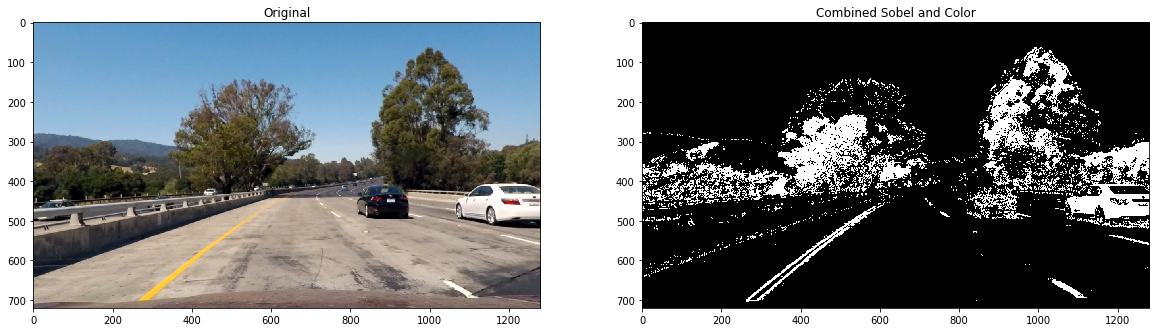

In [6]:
def sobelWithColor(undist):
    sobelX = sobelWithThreshold(sChannel(undist),10,160,1,0)
    sobelY = sobelWithThreshold(sChannel(undist),10,160,0,1)
    combined_sobel = np.zeros_like(sobelX) 
    combined_sobel[((sobelX == 1) & (sobelY == 1))] = 1

    color = combined_color(undist)

    combined = np.zeros_like(sobelX)
    combined[((combined_sobel == 1) | (color == 1))] = 1    
    return combined

combined = sobelWithColor(undist)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)) 
axes[0].set_title('Original') 
axes[1].imshow(combined,cmap='gray') 
axes[1].set_title('Combined Sobel and Color')


In [ ]:
###Compute Perspective Transform Matrix and Warp image

Text(0.5,1,'Warped Image')

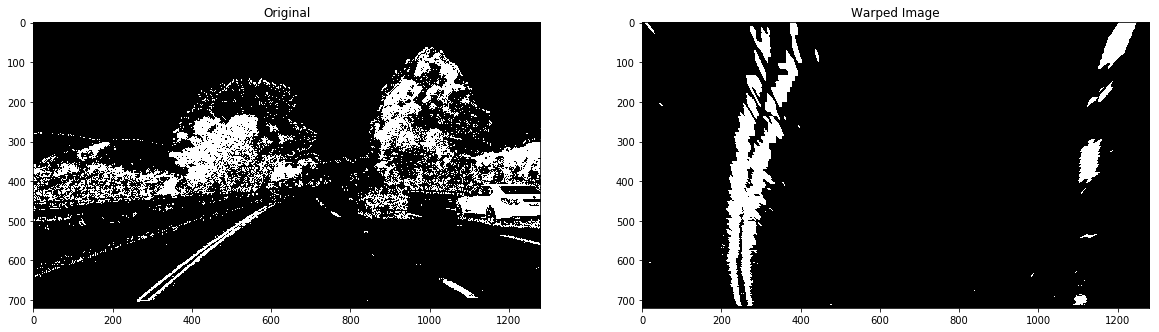

In [7]:
#Four point coordinates which define area to be warped
#Basically lane lines a within this points

bottomY = 720
topY = 455

left1 = (190, bottomY)
left1_x, left1_y = left1
left2 = (585, topY)
left2_x, left2_y = left2

right1 = (705, topY)
right1_x, right1_y = right1

right2 = (1130, bottomY)
right2_x, right2_y = right2


src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])

nX = gray.shape[1]
nY = gray.shape[0]
img_size = (nX, nY)
offset = 200
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(combined, M, (testImage.shape[1], testImage.shape[0]))

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(combined,cmap='gray') 
axes[0].set_title('Original') 
axes[1].imshow(warped,cmap='gray') 
axes[1].set_title('Warped Image')





In [ ]:
###Sliding window for fitting lane lines

(720, 0)

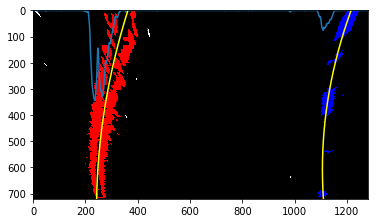

In [8]:
def fit_Left_Right_Line(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return (left_lane_inds,right_lane_inds,left_fitx,right_fitx,nonzeroy,nonzerox,ploty,left_fit,right_fit,lefty,leftx,righty,rightx)


left_lane_inds,right_lane_inds,left_fitx,right_fitx,nonzeroy,nonzerox,ploty,left_fit,right_fit,lefty,leftx,righty,rightx = fit_Left_Right_Line(warped) 
out_img = np.dstack((warped, warped, warped))*255
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


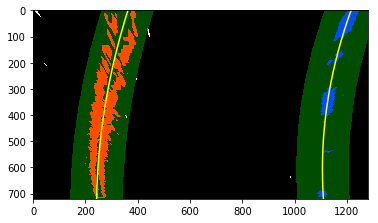

In [9]:
def drawLanes(warped,margin):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
drawLanes(warped,100)    


In [ ]:
###Draw lane lines back to original image

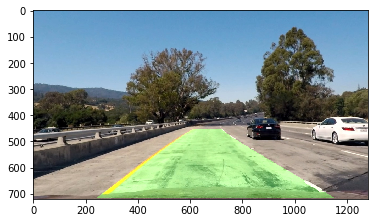

In [10]:
def drawLanesOnOriginal(undist,left_fit,right_fit):
    yMax = undist.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return output

output = drawLanesOnOriginal(undist,left_fit,right_fit)
plt.imshow(cv2.cvtColor( output, cv2.COLOR_BGR2RGB ))

In [11]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/820 # meters per pixel in x dimension

def calculateCurvature(leftx,rightx):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #print(left_curverad,right_curverad)
    
    return (left_curverad, right_curverad,left_fit_cr,right_fit_cr)

In [ ]:
### Write curvature and car position on the image

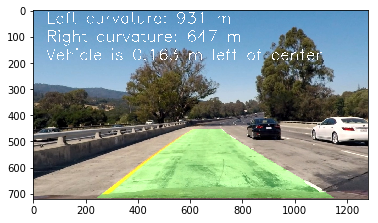

In [12]:
def writeCurvatureAndPosition(output,leftx,rightx):
    left_curverad, right_curverad,left_fit_cr,right_fit_cr = calculateCurvature(leftx,rightx)
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    lineRight = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.3f} m left'.format(diffFromVehicle)
    else:
        message = '{:.3f} m right'.format(-diffFromVehicle)

    # Draw info
    fontScale=2
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

output = writeCurvatureAndPosition(output,left_fitx,right_fitx)
plt.imshow(cv2.cvtColor( output, cv2.COLOR_BGR2RGB ))

In [ ]:
###Entire pipeline

In [13]:
def processImage2(testImage):
    #Undistort Image using precomputed distortion matrices
    undist = cv2.undistort(testImage, mtx, dist, None, mtx)
    
    #Combine gradients and Yellow/White colors to get edges
    combined = sobelWithColor(undist)
        
    #Warp the image to see the lanes from birds view
    warped = cv2.warpPerspective(combined, M, (testImage.shape[1], testImage.shape[0]))

    #Fit lines to lanes
    left_lane_inds,right_lane_inds,left_fitx,right_fitx,nonzeroy,nonzerox,ploty,left_fit,right_fit,lefty,leftx,righty,rightx = fit_Left_Right_Line(warped) 
    
    #Draw Lanes on the original image
    output = drawLanesOnOriginal(undist,left_fit,right_fit)
    
    #Write the curvature and vehicle center
    output = writeCurvatureAndPosition(output,left_fitx,right_fitx)
    
    return output



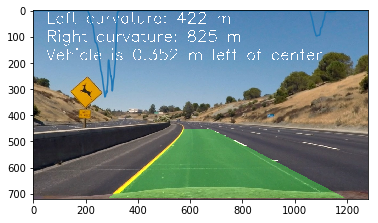

In [14]:
#Test the pipeline
image = cv2.imread("../test_images/test2.jpg")
output = processImage2(image)
plt.imshow(cv2.cvtColor( output, cv2.COLOR_BGR2RGB ))


In [ ]:
###Process Video

[MoviePy] >>>> Building video ../output_images/project_video.mp4
[MoviePy] Writing video ../output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:44<00:00,  4.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video.mp4 



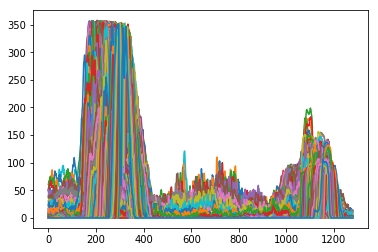

In [15]:
from moviepy.editor import VideoFileClip
inputClip = VideoFileClip('../project_video.mp4')
clip = inputClip.fl_image(processImage2)
clip.write_videofile('../output_images/project_video.mp4', audio=False)